# <center>A3. BBC News Articles</center> 

<h2><center>Contents Legend</center></h2>

<center><a href= "#1.-Dependencies">Dependencies</a></center>
<center><a href= "#2.-Pre-processing-Dataset">Pre-processing Dataset</a></center>
<center><a href= "#3.-Normal-Cleaning">Normal Cleaning</a></center>
<center><a href= "#4.-Term-Frequency-Filter">Term Frequency Filter</a></center>
<center><a href= "#5.-Part-of-Speech-Filter">Part of Speech Filter</a></center>
<center><a href= "#6.-LSI-LDA-1">LSI LDA 1</a></center>
<center><a href= "#7.-LSI-LDA-2">LSI LDA 2</a></center>
<center><a href= "#8.-LSI-LDA-3">LSI LDA 3</a></center>
<center><a href= "#9.-RESULTS">RESULTS</a></center>
<center><a href= "#10.-BONUS">BONUS</a></center>

## 1. Dependencies

In [36]:
import nltk
from nltk.corpus import stopwords
import pandas as pd
from string import punctuation
import re
from gensim.models import TfidfModel, LsiModel, CoherenceModel, LdaModel
import numpy as np
from gensim.corpora import Dictionary
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

<a href= "#A3.-BBC-News-Articles">Back to Top</a>

## 2. Pre-processing Dataset

In [5]:
bbc = pd.read_csv("BBC-articles.csv")
bbc.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,napster offers rented music to go music downlo...
freq,511,2


In [99]:
# cleaner function : removes punctuation, fullstops, stopwords, len(words)>2 
def corpuscleaner(inp):
    inp = inp.strip(punctuation).lower()
    inp = re.sub(r'[!?,.\:;\n\t]+', '', inp)
    word= nltk.tokenize.word_tokenize(inp)                                         # word tokenization
    word = [x for x in word if x.isalpha()]                                        # filtering non-alphabet
    word = [x for x in word if x not in stopwords.words('english') and len(x) > 2] # filtering stopwords & small words 
    return word

<a href= "#A3.-BBC-News-Articles">Back to Top</a>

## 3. Normal Cleaning

In [7]:
# after normal cleaning of the text corpus (punctuation removal, stopword removal, etc.)
def normal(bbc):
    token = []
    for i in bbc.index:
        words = corpuscleaner(bbc.loc[i, 'text'])                        # calling basic function
        wordnet = nltk.stem.WordNetLemmatizer()                          # Normalization using Lemmatization technique
        lemmatized_words = [wordnet.lemmatize(w) for w in words]         # keeping lemmatized words
        token.append(lemmatized_words)                                   # appending to empty token list        
    my_dict = Dictionary(token)                                          # Converting words into a dictonary Tokenization 
    return my_dict,token 

<a href= "#A3.-BBC-News-Articles">Back to Top</a>

## 4. Term Frequency Filter

In [8]:
# with term frequency filter, to exclude the top 10% of the most frequent words and words that appear < 5 times
def term_freq(bbc):
    token = []
    for i in bbc.index:
        words = corpuscleaner(bbc.loc[i, 'text'])
        token.append(words)                             # appended to token list
    my_dict = Dictionary(token)                         # Converted words into a dictonary tokenization                                                        
    my_dict.filter_extremes(no_below=5, no_above=0.90)  # excluded top 10% and words freq < 5 times
    return my_dict,token

<a href= "#A3.-BBC-News-Articles">Back to Top</a>

## 5. Part of Speech Filter

In [9]:
# part of speech filter to limit your TD-IDF matrix to just nouns 
def noun(bbc):
    token = []
    for i in bbc.index:
        words = corpuscleaner(bbc.loc[i, 'text'])
        altered_text=' '.join([w for w in words])
        blob_object = TextBlob(altered_text)
        #filtering the word list with nouns (NN: Noun, NNP: Proper Noun, NNS: Plural Noun, NNPS: Proper plural Noun )
        word_list_nouns = [word for word,pos in blob_object.tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
        token.append(word_list_nouns)                         #appended to token list
    my_dict = Dictionary(token)                               #Converted words into a dictonary tokenization
    return my_dict,token

<a href= "#A3.-BBC-News-Articles">Back to Top</a>

## coherence to find optimal no of topics for each model

In [10]:
def maxCoherence(corpus, isLsi,my_dict,token):
    coherence_values = []
    model_list = []
    min_topics, max_topics, step = 1, 10, 1
    for i in range(min_topics, max_topics, step):
        if (isLsi) :
            model = LsiModel(corpus, id2word=my_dict, num_topics=i)
        else:
            model = LdaModel(corpus, id2word=my_dict, num_topics=i)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=token, dictionary=my_dict, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return coherence_values.index(max(coherence_values))

## keywords

In [11]:
def getkeywords(model, corpus): 
    # Init output
    topickeyword_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:                  # => dominant topic
                wp = model.show_topic(topic_num, topn=5)
                #topn = 5 gives top 5 kwywords 
                topic_keywords = ", ".join([word for word, prop in wp])
                topickeyword_df = topickeyword_df.append(pd.Series([topic_keywords]), ignore_index=True)
            else:
                break
    return(topickeyword_df)

## model

In [12]:
def models_method(clean_type):
    
    my_dict,token=clean_type(bbc)
    dtm = [my_dict.doc2bow(doc) for doc in token] #convert a list of words to bag of words
    tfidf = TfidfModel(dtm) # TF-IDF Vectorization for the document term matrix
    tfidf = tfidf[dtm]

    # Gensim: LSI
    lsi_model = LsiModel(corpus=tfidf, id2word=my_dict, num_topics=maxCoherence(tfidf,isLsi=True,my_dict = my_dict,token = token))

    # Gensim: LDA
    lda_model = LdaModel(corpus=tfidf, id2word=my_dict, num_topics=maxCoherence(tfidf,isLsi=False,my_dict = my_dict,token = token))
    return lsi_model,lda_model,tfidf

## 6. LSI LDA 1

In [13]:
lsi_model_1,lda_model_1,tfidf = models_method(normal)
# add top 5 keywords for each model into the dataframe after vectorization 
bbc['LSI Keywords (normal)'] = getkeywords(model=lsi_model_1, corpus=tfidf)
bbc['LDA Keywords (normal)'] = getkeywords(model=lda_model_1, corpus=tfidf)

In [14]:
bbc.head(10)

,category,text,LSI Keywords (normal),LDA Keywords (normal)
0,tech,tv future in the hands of viewers with home th...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone"
1,business,worldcom boss left books alone former worldc...,"labour, election, blair, tax, brown","game, award, blair, bush, film"
2,sport,tigers wary of farrell gamble leicester say ...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone"
3,sport,yeading face newcastle in fa cup premiership s...,"mobile, phone, film, award, best","conte, film, halifax, juninho, price"
4,entertainment,ocean s twelve raids box office ocean s twelve...,"labour, election, blair, tax, brown","conte, film, halifax, juninho, price"
5,politics,howard hits back at mongrel jibe michael howar...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone"
6,politics,blair prepares to name poll date tony blair is...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone"
7,sport,henman hopes ended in dubai third seed tim hen...,"mobile, phone, film, award, best","game, award, blair, bush, film"
8,sport,wilkinson fit to face edinburgh england captai...,"mobile, phone, film, award, best","game, award, blair, bush, film"
9,entertainment,last star wars not for children the sixth an...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone"


<a href= "#A3.-BBC-News-Articles">Back to Top</a>

## 7. LSI LDA 2

In [15]:
lsi_model_2,lda_model_2,tfidf = models_method(term_freq)
# add top 5 keywords for each model into the dataframe after vectorization 
bbc['LSI Keywords (term_freq)'] = getkeywords(model=lsi_model_2, corpus=tfidf)
bbc['LDA Keywords (term_freq)'] = getkeywords(model=lda_model_2, corpus=tfidf)

In [16]:
bbc.head(10)

,category,text,LSI Keywords (normal),LDA Keywords (normal),LSI Keywords (term_freq),LDA Keywords (term_freq)
0,tech,tv future in the hands of viewers with home th...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, blair, election, people, brown","mobile, music, phones, holmes, sales"
1,business,worldcom boss left books alone former worldc...,"labour, election, blair, tax, brown","game, award, blair, bush, film","yukos, russian, gazprom, court, oil","mobile, music, phones, holmes, sales"
2,sport,tigers wary of farrell gamble leicester say ...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, blair, election, people, brown","blair, labour, party, election, prime"
3,sport,yeading face newcastle in fa cup premiership s...,"mobile, phone, film, award, best","conte, film, halifax, juninho, price","labour, blair, election, people, brown","blair, labour, party, election, prime"
4,entertainment,ocean s twelve raids box office ocean s twelve...,"labour, election, blair, tax, brown","conte, film, halifax, juninho, price","labour, blair, election, people, brown","mobile, music, phones, holmes, sales"
5,politics,howard hits back at mongrel jibe michael howar...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, election, blair, brown, party","blair, labour, party, election, prime"
6,politics,blair prepares to name poll date tony blair is...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, election, blair, brown, party","blair, labour, party, election, prime"
7,sport,henman hopes ended in dubai third seed tim hen...,"mobile, phone, film, award, best","game, award, blair, bush, film","labour, blair, election, people, brown","mobile, music, phones, holmes, sales"
8,sport,wilkinson fit to face edinburgh england captai...,"mobile, phone, film, award, best","game, award, blair, bush, film","film, best, awards, england, award","blair, labour, party, election, prime"
9,entertainment,last star wars not for children the sixth an...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, blair, election, people, brown","blair, labour, party, election, prime"


<a href= "#A3.-BBC-News-Articles">Back to Top</a>

## 8. LSI LDA 3

In [17]:
lsi_model_3,lda_model_3,tfidf = models_method(noun)
# add top 5 keywords for each model into the dataframe after vectorization 
bbc['LSI Keywords (noun)'] = getkeywords(model=lsi_model_3, corpus=tfidf)
bbc['LDA Keywords (noun)'] = getkeywords(model=lda_model_3, corpus=tfidf)

In [18]:
bbc.head(10)

,category,text,LSI Keywords (normal),LDA Keywords (normal),LSI Keywords (term_freq),LDA Keywords (term_freq),LSI Keywords (noun),LDA Keywords (noun)
0,tech,tv future in the hands of viewers with home th...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, blair, election, people, brown","mobile, music, phones, holmes, sales","election, blair, government, party, people","holmes, games, technology, players, game"
1,business,worldcom boss left books alone former worldc...,"labour, election, blair, tax, brown","game, award, blair, bush, film","yukos, russian, gazprom, court, oil","mobile, music, phones, holmes, sales","election, blair, government, party, people","dollar, exports, juninho, growth, spyware"
2,sport,tigers wary of farrell gamble leicester say ...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, blair, election, people, brown","blair, labour, party, election, prime","election, blair, government, party, people","blair, election, party, music, minister"
3,sport,yeading face newcastle in fa cup premiership s...,"mobile, phone, film, award, best","conte, film, halifax, juninho, price","labour, blair, election, people, brown","blair, labour, party, election, prime","election, blair, government, party, people","blair, election, party, music, minister"
4,entertainment,ocean s twelve raids box office ocean s twelve...,"labour, election, blair, tax, brown","conte, film, halifax, juninho, price","labour, blair, election, people, brown","mobile, music, phones, holmes, sales","election, blair, government, party, people","search, software, attacks, sales, google"
5,politics,howard hits back at mongrel jibe michael howar...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, election, blair, brown, party","blair, labour, party, election, prime","election, blair, government, party, people","film, sales, tax, party, blair"
6,politics,blair prepares to name poll date tony blair is...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, election, blair, brown, party","blair, labour, party, election, prime","election, blair, government, party, people","film, sales, tax, party, blair"
7,sport,henman hopes ended in dubai third seed tim hen...,"mobile, phone, film, award, best","game, award, blair, bush, film","labour, blair, election, people, brown","mobile, music, phones, holmes, sales","election, blair, government, party, people","holmes, games, technology, players, game"
8,sport,wilkinson fit to face edinburgh england captai...,"mobile, phone, film, award, best","game, award, blair, bush, film","film, best, awards, england, award","blair, labour, party, election, prime","election, blair, government, party, people","holmes, games, technology, players, game"
9,entertainment,last star wars not for children the sixth an...,"labour, election, blair, tax, brown","search, mobile, tax, labour, phone","labour, blair, election, people, brown","blair, labour, party, election, prime","election, blair, government, party, people","dollar, exports, juninho, growth, spyware"


<a href= "#A3.-BBC-News-Articles">Back to Top</a>

## 9. RESULTS

In [21]:
#write to csv
bbc.to_csv('BBC_Keywords.csv',index=False,encoding='utf-8')

<a href= "#A3.-BBC-News-Articles">Back to Top</a>

## 10. BONUS

In [98]:
#TOPICS of each model 
print('LSI Keywords (normal)')
print(len(set(bbc['LSI Keywords (normal)'])))
print(set(bbc['LSI Keywords (normal)']))
print()

print('LDA Keywords (normal)')
print(len(set(bbc['LDA Keywords (normal)'])))
print(set(bbc['LDA Keywords (normal)']))
print()

print('LSI Keywords (term_freq)')
print(len(set(bbc['LSI Keywords (term_freq)'])))
print(set(bbc['LSI Keywords (term_freq)']))
print()

print('LDA Keywords (term_freq)')
print(len(set(bbc['LDA Keywords (term_freq)'])))
print(set(bbc['LDA Keywords (term_freq)']))
print()

print('LSI Keywords (noun)')
print(len(set(bbc['LSI Keywords (noun)'])))
print(set(bbc['LSI Keywords (noun)']))
print()

print('LDA Keywords (noun)')
print(len(set(bbc['LDA Keywords (noun)'])))
print(set(bbc['LDA Keywords (noun)']))

LSI Keywords (normal)
2
{'mobile, phone, film, award, best', 'labour, election, blair, tax, brown'}

LDA Keywords (normal)
7
{'casino, mobile, hsdpa, gambling, band', 'cabir, argonaut, mock, marvel, election', 'holmes, turkey, renault, job, johansson', 'phone, camera, mobile, music, bmw', 'conte, film, halifax, juninho, price', 'game, award, blair, bush, film', 'search, mobile, tax, labour, phone'}

LSI Keywords (term_freq)
8
{'yukos, music, mobile, software, security', 'mobile, england, growth, phone, sales', 'labour, blair, election, people, brown', 'yukos, england, wales, kenteris, olympic', 'film, best, awards, england, award', 'labour, election, blair, brown, party', 'yukos, russian, gazprom, court, oil', 'film, mobile, best, economy, growth'}

LDA Keywords (term_freq)
3
{'blair, labour, party, election, prime', 'mobile, music, phones, holmes, sales', 'search, market, dollar, growth, china'}

LSI Keywords (noun)
1
{'election, blair, government, party, people'}

LDA Keywords (noun)

## WordClouds of 6 columns

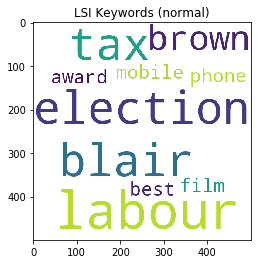

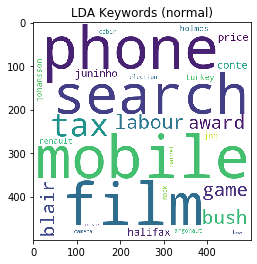

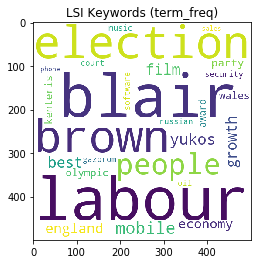

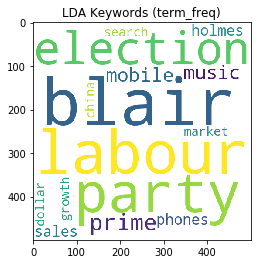

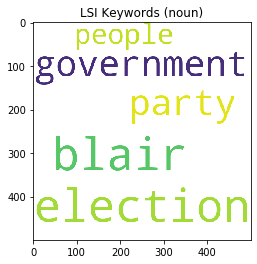

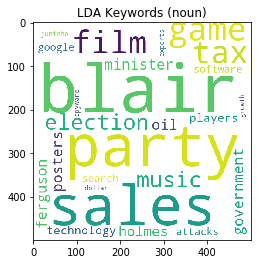

In [75]:
LSI_normal = ' '.join(bbc['LSI Keywords (normal)'])
LDA_normal = ' '.join(bbc['LDA Keywords (normal)'])
LSI_term   = ' '.join(bbc['LSI Keywords (term_freq)'])
LDA_term   = ' '.join(bbc['LDA Keywords (term_freq)'])
LSI_noun   = ' '.join(bbc['LSI Keywords (noun)'])
LDA_noun   = ' '.join(bbc['LDA Keywords (noun)'])

x = [LSI_normal, LDA_normal, LSI_term, LDA_term, LSI_noun, LDA_noun]
j = 2
for i in x:
    wordcloud = WordCloud(width=500, height=500, background_color='white', collocations=False, min_font_size=12).generate(i)
    plt.imshow(wordcloud)
    plt.title('{}'.format(bbc.columns[j])) 
    plt.show()
    j += 1

## As per the above wordclouds, LDA normal seems to have worked best in this project

# <center>THANK YOU</center> 

<a href= "#A3.-BBC-News-Articles">Back to Top</a>